# Assignment: Data Wrangling
### `! git clone https://github.com/ds3001f25/wrangling_assignment.git`
### Do Q1 and Q2
### Reading material: `tidy_data.pdf`

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? 
3. Dummy variable: For the pretrial data covered in the lecture `./data/justice_data.parquet`, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

Q1.1

In [21]:
import pandas as pd

# load dataset
airbnb = pd.read_csv("/Users/lingyueji/Desktop/DS3001/wrangling_assignment/data/airbnb_hw.csv")

# 1. Remove non-numeric characters (commas, dollar signs, etc.) from Price
airbnb["Price_clean"] = (
    airbnb["Price"]
    .astype(str)  # make sure it's a string
    .str.replace(r"[^0-9.]", "", regex=True)  # keep only numbers and decimal points
)

# 2. Convert to numeric type
airbnb["Price_clean"] = pd.to_numeric(airbnb["Price_clean"], errors="coerce")

# 3. Count missing values
missing_count = airbnb["Price_clean"].isna().sum()
total_count = len(airbnb)
missing_ratio = missing_count / total_count

print(f"Total rows: {total_count}")
print(f"Missing values: {missing_count}")
print(f"Missing ratio: {missing_ratio:.2%}")

Total rows: 30478
Missing values: 0
Missing ratio: 0.00%


Q1.2

In [22]:
import pandas as pd
import numpy as np

# Load data
uof = pd.read_csv("/Users/lingyueji/Desktop/DS3001/wrangling_assignment/data/mn_police_use_of_force.csv", low_memory=False)

# 1) subject_injury already has values in {"Yes","No", NaN}
#    -> Just copy to a normalized column for clarity
uof["subject_injury_norm"] = uof["subject_injury"]

# 2) Missingness summary
missing_ratio = uof["subject_injury_norm"].isna().mean()
print(f"Missing ratio (before imputation): {missing_ratio:.2%}")

# 3) Does missingness look systematic? Check by force_type
uof["force_type_norm"] = (
    uof["force_type"].astype(str).str.strip().str.lower().replace({"nan": np.nan})
)

top_force = uof["force_type_norm"].value_counts().head(10).index.tolist()
missing_by_force = (
    uof.assign(missing=uof["subject_injury_norm"].isna())
       .loc[uof["force_type_norm"].isin(top_force)]
       .groupby("force_type_norm")["missing"]
       .mean()
       .sort_values(ascending=False)
)
print("\nMissing ratio by top force_type (before imputation):")
print(missing_by_force)

# 4) Imputation policy — pick ONE of the following:

## (A) Conservative policy: impute missing -> "No"
# uof["subject_injury_imputed"] = uof["subject_injury_norm"].fillna("No")

## (B) Severity-based policy: high-severity force -> "Yes", otherwise "No"
high_severity_keywords = [
    "firearm", "taser", "k9", "canine", "pepper", "chemical",
    "impact", "baton", "less lethal", "beanbag"
]
def impute_injury(row):
    val = row["subject_injury_norm"]
    if pd.notna(val):
        return val
    f = str(row["force_type_norm"])
    return "Yes" if any(k in f for k in high_severity_keywords) else "No"

uof["subject_injury_imputed"] = uof.apply(impute_injury, axis=1)

# 5) Post-imputation checks
post_missing = uof["subject_injury_imputed"].isna().mean()
dist_after = uof["subject_injury_imputed"].value_counts(normalize=True)
print("\nMissing ratio (after imputation):", f"{post_missing:.2%}")
print("\nDistribution after imputation:")
print(dist_after)

# 6) Crosstab with force_type (row-normalized)
ct = pd.crosstab(
    uof["force_type_norm"],
    uof["subject_injury_imputed"],
    normalize="index"
).round(3).sort_values(by="Yes", ascending=False)

print("\nRow-normalized crosstab of force_type × subject_injury (after imputation):")
print(ct.head(15))


Missing ratio (before imputation): 76.19%

Missing ratio by top force_type (before imputation):
force_type_norm
less lethal                    1.000000
maximal restraint technique    1.000000
chemical irritant              0.892028
taser                          0.753634
bodily force                   0.747720
baton                          0.500000
improvised weapon              0.500000
police k9 bite                 0.402597
gun point display              0.259615
less lethal projectile         0.000000
Name: missing, dtype: float64

Missing ratio (after imputation): 0.00%

Distribution after imputation:
subject_injury_imputed
No     0.678375
Yes    0.321625
Name: proportion, dtype: float64

Row-normalized crosstab of force_type × subject_injury (after imputation):
subject_injury_imputed          No    Yes
force_type_norm                          
baton                        0.000  1.000
less lethal                  0.000  1.000
police k9 bite               0.026  0.974
chemical ir

Q1.3

In [23]:
import pandas as pd
import numpy as np

# Load the dataset
justice_df = pd.read_parquet('/Users/lingyueji/Desktop/DS3001/wrangling_assignment/data/justice_data.parquet')

# Clean the 'WhetherDefendantWasReleasedPretrial' column by replacing 'None' with 'np.nan' (missing values)
justice_df['WhetherDefendantWasReleasedPretrial'] = justice_df['WhetherDefendantWasReleasedPretrial'].replace({None: np.nan})

# Display the cleaned data for the 'WhetherDefendantWasReleasedPretrial' column
print(justice_df[['WhetherDefendantWasReleasedPretrial']].head())

   WhetherDefendantWasReleasedPretrial
0                                    9
1                                    0
2                                    0
3                                    0
4                                    1


Q1.4

In [24]:
# Clean the 'ImposedSentenceAllChargeInContactEvent' column
# Based on the values in the 'SentenceTypeAllChargesAtConvictionInContactEvent' column, 
# decide how to fill the 'ImposedSentenceAllChargeInContactEvent' column
for index, row in justice_df.iterrows():
    # Check if 'SentenceTypeAllChargesAtConvictionInContactEvent' is missing (NaN)
    if pd.isnull(row['SentenceTypeAllChargesAtConvictionInContactEvent']):
        # If it is missing, set 'ImposedSentenceAllChargeInContactEvent' to NaN
        justice_df.at[index, 'ImposedSentenceAllChargeInContactEvent'] = np.nan

# Display the cleaned data for the 'ImposedSentenceAllChargeInContactEvent' column
print(justice_df[['ImposedSentenceAllChargeInContactEvent']].head())


  ImposedSentenceAllChargeInContactEvent
0                                       
1                                     60
2                                     12
3                       .985626283367556
4                                       


**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks (Hint: `GSAF5.xls`).

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
4. Clean the Age variable and make a histogram of the ages of the victims.
5. What proportion of victims are male?
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

Q2.1

In [25]:
import pandas as pd

# Q2.1: Load the dataset from the Excel file
shark_attack_df = pd.read_excel('/Users/lingyueji/Desktop/DS3001/wrangling_assignment/GSAF5.xls')
# Check the first few rows 
print(shark_attack_df.head())

               Date    Year        Type      Country  \
0  16th August 2025  2025.0    Provoked          USA   
1       18th August  2025.0  Unprovoked    Australia   
2       17th August  2025.0  Unprovoked      Bahamas   
3        7th August  2025.0  Unprovoked    Australia   
4        1st August  2025.0  Unprovoked  Puerto Rico   

                               State                             Location  \
0                            Florida               Cayo Costa Boca Grande   
1                                NSW                       Cabarita Beach   
2  Atlantic Ocean near Big Grand Cay  North of Grand Bahama near Freeport   
3                                NSW                        Tathra Beach    
4                           Carolina                       Carolina Beach   

       Activity          Name Sex Age  ...                 Species   \
0       Fishing   Shawn Meuse   M   ?  ...  Lemon shark 1.8 m (6ft)   
1       Surfing     Brad Ross   M   ?  ...  5m (16.5ft) Gr

Q2.2

In [26]:
# Drop columns with all missing (NaN) values
shark_attack_df.dropna(axis=1, how='all', inplace=True)

# Check the resulting dataframe to make sure it's cleaned up
print(shark_attack_df.head())

               Date    Year        Type      Country  \
0  16th August 2025  2025.0    Provoked          USA   
1       18th August  2025.0  Unprovoked    Australia   
2       17th August  2025.0  Unprovoked      Bahamas   
3        7th August  2025.0  Unprovoked    Australia   
4        1st August  2025.0  Unprovoked  Puerto Rico   

                               State                             Location  \
0                            Florida               Cayo Costa Boca Grande   
1                                NSW                       Cabarita Beach   
2  Atlantic Ocean near Big Grand Cay  North of Grand Bahama near Freeport   
3                                NSW                        Tathra Beach    
4                           Carolina                       Carolina Beach   

       Activity          Name Sex Age  ...                 Species   \
0       Fishing   Shawn Meuse   M   ?  ...  Lemon shark 1.8 m (6ft)   
1       Surfing     Brad Ross   M   ?  ...  5m (16.5ft) Gr

Q2.3

In [27]:
# Clean the 'Year' column by converting it to numeric values (force errors to NaN)
shark_attack_df['Year'] = pd.to_numeric(shark_attack_df['Year'], errors='coerce')

# Filter rows for attacks since 1940
shark_attack_df = shark_attack_df[shark_attack_df['Year'] >= 1940]

# Describe the range of years
year_range = shark_attack_df['Year'].describe()

# Check how attacks have changed over time (e.g., yearly attack counts)
attacks_by_year = shark_attack_df['Year'].value_counts().sort_index()

# Display the results
print(year_range)
print(attacks_by_year)


count    5507.000000
mean     1992.225350
std        24.169336
min      1940.000000
25%      1970.000000
50%      2000.000000
75%      2013.000000
max      2026.000000
Name: Year, dtype: float64
Year
1940.0     24
1941.0     27
1942.0     41
1943.0     28
1944.0     31
         ... 
2022.0     98
2023.0    109
2024.0     52
2025.0     48
2026.0      1
Name: count, Length: 87, dtype: int64


Q2.4

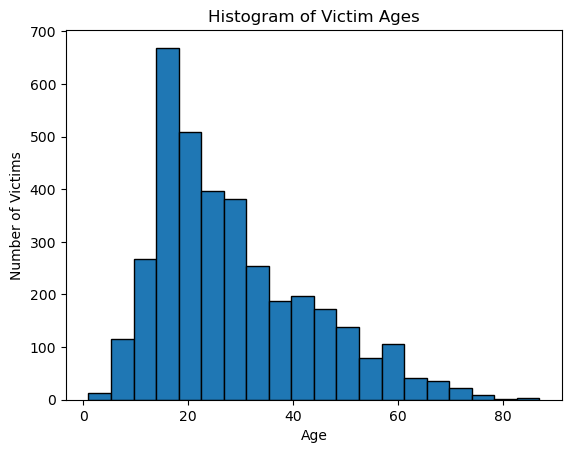

In [28]:
import matplotlib.pyplot as plt

# Clean the 'Age' column (convert to numeric, set errors to NaN)
shark_attack_df['Age'] = pd.to_numeric(shark_attack_df['Age'], errors='coerce')

# Plot a histogram of the ages
plt.hist(shark_attack_df['Age'].dropna(), bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Victims')
plt.title('Histogram of Victim Ages')
plt.show()

Q2.5

In [29]:
# Calculate the proportion of male victims
male_proportion = shark_attack_df['Sex'].value_counts(normalize=True).get('M', 0)

print(f"Proportion of male victims: {male_proportion:.2f}")


Proportion of male victims: 0.86


Q2.6

In [30]:
# Standardize the text (lowercase) and clean the 'Type' column
shark_attack_df['Type'] = shark_attack_df['Type'].str.strip().str.lower()

# Replace variations of 'Unprovoked' and 'Provoked' with 'Unprovoked' and 'Provoked'
shark_attack_df['Type'] = shark_attack_df['Type'].replace({
    'unprovoked': 'Unprovoked',
    'provoked': 'Provoked',
    'questionable': 'Unknown',
    'unverified': 'Unknown',
    'unconfirmed': 'Unknown',
    'watercraft': 'Unknown',
    'sea disaster': 'Unknown',
    'invalid': 'Unknown',
    'under investigation': 'Unknown',
    'boat': 'Unknown',
    '': 'Unknown',
    '?': 'Unknown',
    np.nan: 'Unknown'  # Also replace NaN with 'Unknown'
})

# Check the unique values after cleaning
print(shark_attack_df['Type'].unique())


# Calculate the proportion of unprovoked attacks
unprovoked_proportion = shark_attack_df['Type'].value_counts(normalize=True).get('Unprovoked', 0)

print(f"Proportion of unprovoked attacks: {unprovoked_proportion:.2f}")


['Provoked' 'Unprovoked' 'Unknown']
Proportion of unprovoked attacks: 0.74


Q2.7

In [31]:
# Standardize the text (convert to uppercase and strip any spaces)
shark_attack_df['Fatal Y/N'] = shark_attack_df['Fatal Y/N'].str.upper().str.strip()

# Replace invalid or misrepresented values with 'Unknown'
shark_attack_df['Fatal Y/N'] = shark_attack_df['Fatal Y/N'].replace({
    'F': 'Unknown',
    'M': 'Unknown',
    'Nq': 'Unknown',
    'NQ': 'Unknown',
    'UNKNOWN': 'Unknown',
    np.nan: 'Unknown',
    '': 'Unknown',
    'Y x 2': 'Y',  # Handling the 'Y x 2' case as 'Y'
    2017: 'Unknown',  # Handle the numeric value 2017 as 'Unknown'
    ' N': 'N',  # Removing leading spaces and correcting the value
    'Y X 2': 'Y',
})

# Display the cleaned 'Fatal Y/N' column
print(shark_attack_df['Fatal Y/N'].value_counts())



Fatal Y/N
N          4221
Y           825
Unknown     461
Name: count, dtype: int64


Q2.8

In [33]:
# Clean the 'Sex' column by:
# 1. Stripping any leading or trailing spaces
# 2. Converting everything to uppercase
# 3. Replacing any invalid values with 'Unknown'
shark_attack_df['Sex'] = shark_attack_df['Sex'].str.upper().str.strip()

# Replace any unexpected values (e.g., 'lli') with 'Unknown'
shark_attack_df['Sex'] = shark_attack_df['Sex'].replace({
    'M': 'M',  # Male
    'F': 'F',  # Female
    'M ': 'M', # Handle any spaces after 'M'
    'f': 'F',  # Handle lowercase 'f'
    'lli': 'Unknown',  # Example of an invalid value
    'LLI': 'Unknown',  # Another invalid value
    np.nan: 'Unknown',  # Missing values
    'UNKNOWN': 'Unknown',
    'M X 2': 'M',  # Handle the 'M x 2' case as 'M'
    'N': 'Unknown',  # Handle 'N' as 'Unknown'
    '.': 'Unknown',  # Handle '.' as 'Unknown'
})

# Check if unprovoked attacks are more likely on men or women
unprovoked_gender = shark_attack_df[shark_attack_df['Type'] == 'Unprovoked']['Sex'].value_counts(normalize=True)

# Calculate the fatality rate for unprovoked vs provoked attacks
fatality_by_type = shark_attack_df.groupby('Type')['Fatal Y/N'].value_counts(normalize=True).unstack()

# Calculate the fatality rate by gender
fatality_by_gender = shark_attack_df.groupby('Sex')['Fatal Y/N'].value_counts(normalize=True).unstack()

# Display results
print(f"Proportion of unprovoked attacks on men vs women:\n{unprovoked_gender}")
print(f"\nFatality rate by attack type:\n{fatality_by_type}")
print(f"\nFatality rate by gender:\n{fatality_by_gender}")


Proportion of unprovoked attacks on men vs women:
Sex
M          0.815764
F          0.149585
Unknown    0.034651
Name: proportion, dtype: float64

Fatality rate by attack type:
Fatal Y/N          N   Unknown         Y
Type                                    
Provoked    0.957692  0.017308  0.025000
Unknown     0.411699  0.448819  0.139483
Unprovoked  0.819180  0.012933  0.167887

Fatality rate by gender:
Fatal Y/N         N   Unknown         Y
Sex                                    
F          0.794444  0.081944  0.123611
M          0.773189  0.074527  0.152284
Unknown    0.657837  0.174393  0.167770


Q2.9

In [34]:
# Clean the 'Species' column and check for attacks by white sharks
shark_attack_df['Species '] = shark_attack_df['Species '].str.split().str[0]  # Split and keep the first word (e.g., "White Shark")

# Calculate the proportion of attacks by white sharks
white_shark_proportion = shark_attack_df['Species '].value_counts(normalize=True).get('White', 0)

print(f"Proportion of attacks by white sharks: {white_shark_proportion:.2f}")


Proportion of attacks by white sharks: 0.13
